In [147]:
from datetime import datetime

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
import torchtext.vocab as vocab

# internal imports
import evaluation.evaluate as val
from modelling import util
import visualization as vis

## Get and explore data

In [99]:
# https://zenodo.org/records/3355823
file_name = "ecommerceDataset.csv"
data = pd.read_csv(file_name, header=None)
data.columns = ["category", "description"]

In [100]:
print("Rows, cols:", data.shape)
data.head(10)

Rows, cols: (50425, 2)


,category,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
5,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
6,Household,Paper Plane Design Starry Night Vangoh Wall Ar...
7,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
8,Household,SAF 'Ganesh Modern Art Print' Painting (Synthe...
9,Household,Paintings Villa UV Textured Modern Art Print F...


Category distribution

In [101]:
data["category"].value_counts()

Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: category, dtype: int64

Description examples

In [102]:
for category in data["category"].unique():
    row_example = data[data["category"] == category].sample(n=100).iloc[0]
    print(f"CATEGORY: {row_example['category']}\nDESCRIPTION:\n{row_example['description']}\n\n")

CATEGORY: Household
DESCRIPTION:
beanbagwala Spaces Therapy Solitaire Fabric 2+1+1 Seater Sofa Set (Grey) Spaces Therapy brings to you premium Fabric Sofa Set to Adorn the lifestyle of your Living Room, Refined Design and comfort which marks Elegance to your living space, this super stylish and trending Solitaire premium Fabric Sofa Set design from Spaces Therapy add the perfect balance to yours living room. It offers a superior comfort seating experience and made of Solid wood frame give it very long and firm durability, Double cushioned provides you with extra softness to make a pleasant seating experience. Very trending Modern design is perfect for contemporary and modern decors. Solitaire premium Fabric Sofa Set collection is more posh and soft than the looks of it .Solitaire Sofa Set provides you all comfort and superior looks to enhance the interior Decor of your Living Room.


CATEGORY: Books
DESCRIPTION:
Relativity the Special General Theory 


CATEGORY: Clothing & Accessories


Handling empty values

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     50425 non-null  object
 1   description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [104]:
data[data["description"].isna()]

,category,description
39330,Clothing & Accessories,NaN


In [105]:
data.dropna(inplace=True)

## Handle duplicates

In [106]:
repeated_messages = data \
    .groupby("description", as_index=False) \
    .agg(
        n_repeats=("category", "count"),
        n_unique_categories=("category", lambda x: len(np.unique(x)))
    )

assert all(repeated_messages["n_unique_categories"] == 1), \
    f"Repeated descriptions with non-unique categories: " + \
    f"{repeated_messages[repeated_messages['n_unique_categories']] > 1}"

repeated_messages = repeated_messages[repeated_messages["n_repeats"] > 1]

print(f"Count of repeated messages (unique): {repeated_messages.shape[0]}")
print(f"Total number: {repeated_messages['n_repeats'].sum()} out of {data.shape[0]}")

repeated_messages.head(10)

Count of repeated messages (unique): 13979
Total number: 36601 out of 50424


,description,n_repeats,n_unique_categories
2,# The Silky Beans 2 KG Premium Bean Bag Filler...,4,1
3,# The Silky Beans 500 Gram Premium A-Grade for...,4,1
4,#Horror,4,1
7,(CERTIFIED REFURBISHED) HP DeskJet 2131 All-in...,2,1
8,(CERTIFIED REFURBISHED) Logitech K230 Wireless...,2,1
11,(CERTIFIED REFURBISHED) Philips BT 106 Bluetoo...,2,1
17,.42x HD Super Wide Angle Panoramic Macro Fishe...,2,1
18,0-Degree Electrical Socket Cover for Indian Pl...,2,1
20,0-Degree Women's Ankle Length Premium Cotton M...,2,1
21,1 12 4PCS Gold Metal Door Knocker Lock Doorpla...,2,1


In [107]:
data.drop_duplicates(inplace=True)
print(f"New dataset size: {data.shape}")
print(data["category"].value_counts())

New dataset size: (27802, 2)
Household                 10564
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: category, dtype: int64


## Languages

In [108]:
# TODO: filter only English texts

## Description lengths

In [109]:
data["description_length"] = data["description"].apply(len)

In [110]:
px.histogram(data, x="description_length", title="Descriptions length distribution")

In [111]:
px.histogram(
    data[data["description_length"] <= 5000],
    x="description_length",
    title="Descriptions length distribution per category",
    color="category",
    barmode="overlay",
    histnorm="density"
)

In [112]:
print("Shortest messages, examples:\n")

for i, row in data.sort_values("description_length").iloc[:7].iterrows():
    print("{} '{}': \n{}\n".format(i, row["category"], row["description"]))

Shortest messages, examples:

31225 'Clothing & Accessories': 
BELT

25918 'Books': 
Sail

25314 'Books': 
Yes!

30433 'Books': 
On War

30411 'Books': 
On War 

25810 'Books': 
Tennis 

23015 'Books': 
Essays 



## Train test eval split

In [113]:
data_train, data_test = train_test_split(data, test_size=0.3)
data_test, data_eval = train_test_split(data_test, test_size=0.5)

In [114]:
data_train.shape, data_test.shape, data_eval.shape

((19461, 3), (4170, 3), (4171, 3))

## Modelling

In [115]:
inference_time_s = dict()
scores = dict()

### Baseline

In [116]:
count_vectorizer = CountVectorizer(max_features=100)
x_train_baseline, y_train_baseline = count_vectorizer.fit_transform(data_train["description"]), data_train["category"]
x_test_baseline, y_test_baseline = count_vectorizer.transform(data_test["description"]), data_test["category"]
x_eval_baseline, y_eval_baseline = count_vectorizer.transform(data_eval["description"]), data_eval["category"]

x_train_baseline = x_train_baseline.toarray()
x_test_baseline = x_test_baseline.toarray()
x_eval_baseline = x_eval_baseline.toarray()

x_train_baseline.shape, x_test_baseline.shape, x_eval_baseline.shape

((19461, 100), (4170, 100), (4171, 100))

In [117]:
ss = StandardScaler()
x_train_baseline = ss.fit_transform(x_train_baseline)
x_test_baseline = ss.transform(x_test_baseline)
x_eval_baseline = ss.transform(x_eval_baseline)

In [118]:
%%capture

lr = LogisticRegression()
lr.fit(x_train_baseline, y_train_baseline)
scores["baseline"] = balanced_accuracy_score(y_test_baseline, lr.predict(x_test_baseline))

In [119]:
print("Balanced accuracy score: {:.1f}%".format(scores["baseline"] * 100))

Balanced accuracy score: 74.7%


In [120]:
vis.draw_confusion_matrix(
    y_test_baseline,
    lr.predict(x_test_baseline),
    lr.classes_,
    label="recall",
    normalize="true"
)

In [121]:
vis.draw_confusion_matrix(
    y_test_baseline,
    lr.predict(x_test_baseline),
    lr.classes_,
    label="precision",
    normalize="pred"
)

In [122]:
vis.show_lr_feature_importance(lr, 0, count_vectorizer)

In [123]:
vis.show_lr_feature_importance(lr, 1, count_vectorizer)

In [124]:
vis.show_lr_feature_importance(lr, 2, count_vectorizer)

In [125]:
vis.show_lr_feature_importance(lr, 3, count_vectorizer)

In [126]:
eval_pred_lr = val.predict_labels(y_test_baseline, lr.predict_proba(x_test_baseline),
                                  lr.predict_proba(x_eval_baseline), lr.classes_)
eval_auto_lr = val.predict_labels(y_test_baseline, lr.predict_proba(x_test_baseline),
                                  lr.predict_proba(x_eval_baseline), lr.classes_, 0.99)
vis.show_predicted_labels_distribution(eval_pred_lr, "baseline")

Inference time estimation

In [131]:
%%time
tic = datetime.now()
x_eval_baseline, y_eval_baseline = count_vectorizer.transform(data_eval["description"]), data_eval["category"]
x_eval_baseline = x_eval_baseline.toarray()
x_eval_baseline = ss.transform(x_eval_baseline)
_ = lr.predict_proba(x_eval_baseline)

inference_time_s["lr"] = (datetime.now() - tic).total_seconds()

CPU times: user 187 ms, sys: 2.6 ms, total: 190 ms
Wall time: 195 ms


### GRU / LSTM

Building vocabulary based on data_train

In [135]:
%%time
corpus_dict = util.CorpusDictionary(data_train["description"]) # custom class
len(corpus_dict.dictionary)

CPU times: user 963 ms, sys: 22.8 ms, total: 986 ms
Wall time: 991 ms


90808

In [141]:
corpus_dict.get_frequencies()[-10:]

[(')', 0.5353270643851806),
 ('a', 0.5517188222599044),
 ('with', 0.5793124710960382),
 ('to', 0.5987359334052721),
 ('for', 0.6347053080520014),
 ('of', 0.6378911669492832),
 ('the', 0.6447253481321618),
 ('and', 0.7436925132315914),
 (',', 0.7564359488207184),
 ('.', 0.8149118750321155)]

Truncating vocabulary based on message frequencies

In [143]:
corpus_dict.truncate_dictionary(min_frequency=0.03)
len(corpus_dict.dictionary)

345

In [144]:
%%time
data_train["vector"] = corpus_dict.transform(data_train["description"])
data_test["vector"] = corpus_dict.transform(data_test["description"])
data_eval["vector"] = corpus_dict.transform(data_eval["description"])

CPU times: user 1.55 s, sys: 32.8 ms, total: 1.58 s
Wall time: 1.59 s


In [145]:
fig = go.Figure(data=[go.Histogram(x=data_train["vector"].apply(len), histnorm='probability')])
fig.update_layout(
    title="Lengths of messages in train dataset (words)",
    width=700,
    height=300
)
fig.show()

max_len = int(np.quantile(data_train["vector"].apply(len), q=0.95))
print("95-quantile length: {}".format(max_len))

95-quantile length: 351


In [148]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out

        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(self.n_hidden, self.n_out)


    def forward(self, sequence, lengths):
        batch_size = sequence.size(1)
        self.hidden = self._init_hidden(batch_size)
        
        embs = self.emb(sequence)
        embs = pack_padded_sequence(embs, lengths, enforce_sorted=True)
        gru_out, self.hidden = self.gru(embs, self.hidden)
        gru_out, lengths = pad_packed_sequence(gru_out)
        dropout = self.dropout(self.hidden[-1])
        output = self.out(dropout)

        return F.log_softmax(output, dim=-1)


    def _init_hidden(self, batch_size):
        return Variable(torch.zeros((1, batch_size, self.n_hidden)))

In [156]:
def get_target(label, total_labels=4):
    target = [0] * total_labels
    target[label_2_idx.get(label)] = 1
    return target

labels = set(data["category"])
label_2_idx = {label: idx for label, idx in zip(sorted(labels), range(len(labels)))}
idx_2_label = [label for label, _ in sorted(label_2_idx.items(), key=lambda x: x[1])]

data_train["target"] = data_train["category"].apply(get_target)
data_test["target"] = data_test["category"].apply(get_target)
data_eval["target"] = data_eval["category"].apply(get_target)

Train loss:	0.8953
Val loss:	1.2492


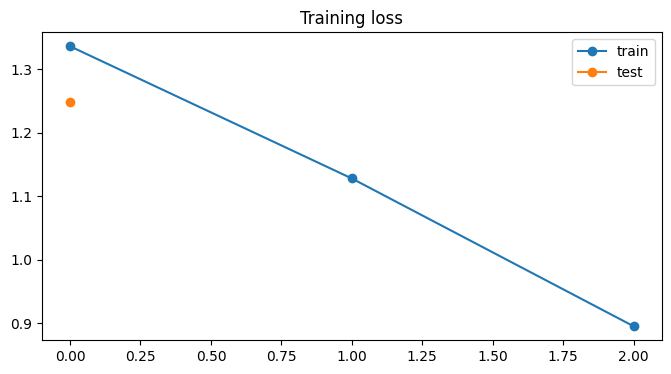

KeyboardInterrupt: 

In [158]:
ds_train = util.PaddedTextVectorDataset( # custom class
    data_train["description"],
    data_train["target"],
    corpus_dict
)
ds_test = util.PaddedTextVectorDataset(
    data_test["description"],
    data_test["target"],
    corpus_dict
)
ds_eval = util.PaddedTextVectorDataset(
    data_eval["description"],
    data_eval["target"],
    corpus_dict
)

train_dl = DataLoader(ds_train, batch_size=512, shuffle=True)
test_dl = DataLoader(ds_test, batch_size=512, shuffle=False)
eval_dl = DataLoader(ds_eval, batch_size=512, shuffle=False)

vocab_size = len(corpus_dict.word_to_idx)
emb_dim = 4
n_hidden = 15
n_out = len(label_2_idx)

model = GRU(vocab_size, emb_dim, n_hidden, n_out)
opt = optim.Adam(model.parameters(), 1e-2)

util.fit(model=model, train_dl=train_dl, test_dl=test_dl, loss_fn=F.cross_entropy, opt=opt, epochs=100)
torch.save(model, "models/gru")